In [1]:
# Setup
import pandas as pd
import numpy as np
import git
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

from barebone import *
from model_util import *

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

/opt/conda/envs/posedemo/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create a numpy array containing all the calculated features Poseformer (HRNet output)
# Exclude fields 0 (identifiers), 1 (number of cycles, duplicate), 2 (orientation), 3 (framerate)
df_calc = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/results/results-poseformer-20230604_3d.csv')
df_calc.drop(['Unnamed: 0', 'n', 'orientation', 'framerate'], axis=1, inplace=True)

df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')

# join the dataframes by subjectId - precalculated features only
df_join = df_calc.set_index('subjectid').join(df_survey.set_index('subjectid')).astype('float32')

# all videos from the new clinical trial have OA=1 
df_join = df_join.fillna(value={'OA_check': 1})
df_join

,time,time_diff,speed,time_sd,speed_sd,n_sit2stand,time_sit2stand,time_diff_sit2stand,speed_sit2stand,time_sd_sit2stand,...,ank_to_hip_dist_sit_3d,ank_to_hip_dist_stand_3d,knee_to_hip_dist_sit_3d,knee_to_hip_dist_stand_3d,height_3d,lknee_angle_first_sit_3d,rknee_angle_first_sit_3d,lknee_angle_first_stand_3d,rknee_angle_first_stand_3d,OA_check
subjectid,,,,,,,,,,,,,,,,,,,,,
kEC7G8DP,11.666667,0.391667,0.43,0.568429,0.109845,5.0,5.000000,-0.083333,1.00,0.164655,...,1.323744,1.663332,1.496001,1.521675,1.594991,238.587860,128.601425,193.616425,166.177704,0.0
GjPHiGli,14.033334,-0.066667,0.36,0.247117,0.030709,5.0,5.266667,-0.791667,0.95,0.203961,...,1.720683,1.897206,1.382583,1.394735,1.656933,106.175110,235.751480,165.187592,165.087326,0.0
RFibHPt7,13.833333,-0.241667,0.36,0.374166,0.059231,5.0,4.333333,-1.166667,1.15,0.180123,...,0.819094,0.748246,1.205347,0.703840,1.571508,254.212967,253.659485,173.260025,173.938721,0.0
gO7Cpt1X,11.500000,0.283333,0.43,0.733333,0.190154,5.0,3.900000,-0.866667,1.28,0.381576,...,1.238144,1.155679,1.259590,0.923143,1.349029,95.654854,84.816811,212.539536,195.628159,0.0
xEIsrkiR,12.266666,-0.500000,0.41,0.972420,0.342664,5.0,2.233333,-2.000000,2.24,0.149963,...,0.957589,1.094586,0.556713,0.686454,1.507073,123.651611,248.940155,172.281143,160.916199,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VID_20230506_175810340,15.366667,-0.511111,0.26,0.682469,0.058440,4.0,5.966667,-1.311111,0.67,0.189113,...,1.055738,1.026740,0.900768,1.066869,1.619607,89.533646,266.958099,190.020660,154.128174,1.0
8elUiJYv,7.400000,0.108333,0.68,0.209338,0.106825,5.0,4.000000,0.100000,1.25,0.172562,...,0.952726,0.550644,1.275098,1.308036,1.506827,249.733643,118.276222,221.429047,195.310013,0.0
PXL_20230505_234002299,14.300000,-0.544444,0.28,0.718554,0.077061,4.0,4.900000,-1.655556,0.82,0.317433,...,0.752801,0.931558,1.016199,1.141191,1.566733,94.272919,92.371521,166.026230,192.597931,1.0


In [9]:
df_join['OA_check'] = df_join['OA_check'].astype(int)
df_join['OA_check']

subjectid
kEC7G8DP                  0
GjPHiGli                  0
RFibHPt7                  0
gO7Cpt1X                  0
xEIsrkiR                  0
                         ..
VID_20230506_175810340    1
8elUiJYv                  0
PXL_20230505_234002299    1
q8FyLMSn                  0
pmYdj2Zc                  0
Name: OA_check, Length: 384, dtype: int64

In [37]:
df_long = pd.melt(df_join[["time_sit2stand", "time_stand2sit", "OA_check"]], "OA_check", var_name="time", value_name="seconds")

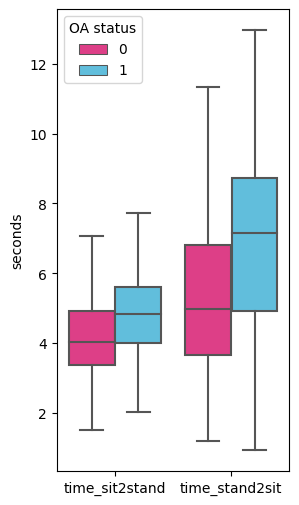

<Figure size 640x480 with 0 Axes>

In [60]:
palette = {0: "#F72585", 1:  "#4CC9F0"}
plt.figure(figsize=(3,6))
ax = sns.boxplot(x="time", hue="OA_check", y="seconds", data=df_long, palette=palette, showfliers = False)
ax.set(xlabel=None)
plt.legend(title='OA status')
plt.savefig("{}/results/boxplot.png".format(homedir))
plt.show()

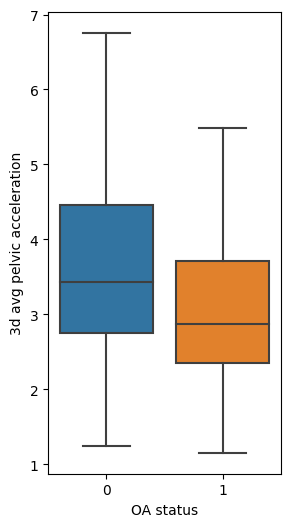

In [69]:
plt.figure(figsize=(3,6))
ax = sns.boxplot(y="pelvic_3d_avg_acc", x="OA_check", data=df_join, showfliers = False)
ax.set(xlabel="OA status", ylabel="3d avg pelvic acceleration")
plt.savefig("{}/results/boxplot_pelvis.png".format(homedir))
plt.show()

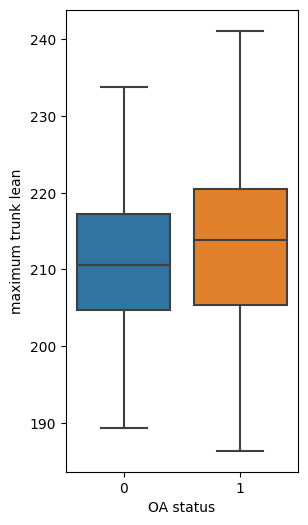

In [68]:
plt.figure(figsize=(3,6))
ax = sns.boxplot(y="trunk_lean_max", x="OA_check", data=df_join, showfliers = False)
ax.set(xlabel="OA status", ylabel="maximum trunk lean")
plt.savefig("{}/results/boxplot_trunk.png".format(homedir))
plt.show()